<a href="https://colab.research.google.com/github/mamun216/portfolio-projects/blob/master/Sarcasm_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Prediction from news headline

# Business Context
Electronic journalism powered with Social media has become one of the major sources of information consumption lately. Many media houses are using creative ways in order to tap into increasing views on posts. One of the ways is using sarcastic headlines as click baits. A model that is able to predict whether a piece of headline is sarcastic or not can be useful for media houses in order to analyse their quarterly earnings by strategy. Also, from a reader's perspective, search engines can utilise this information of sarcasm and depending on the reader’s preference, recommend similar articles to them. The goal is to build a model to detect whether a sentence is sarcastic or not, using classifical machine learning model.

## Problem Overview
In this challenge, we will work on a dataset that contains news headlines - which are aimed to be written in a sarcastic manner by the news author. Our job here is to build our NLP models and predict whether the headline is sarcastic or not.

# About the Data
Each record of dataset consists of two attributes:

- is_sarcastic: 1 if the record is sarcastic otherwise 0. This is the target variable.

- headline: this is the headline of the news article

# Importing libraries

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Dataset loading and reading

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/nlp task/Train_Data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/nlp task/Test_Data.csv")


In [4]:
train_data.head()

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44262 entries, 0 to 44261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      44262 non-null  object
 1   is_sarcastic  44262 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 691.7+ KB


# Exploratory data analysis

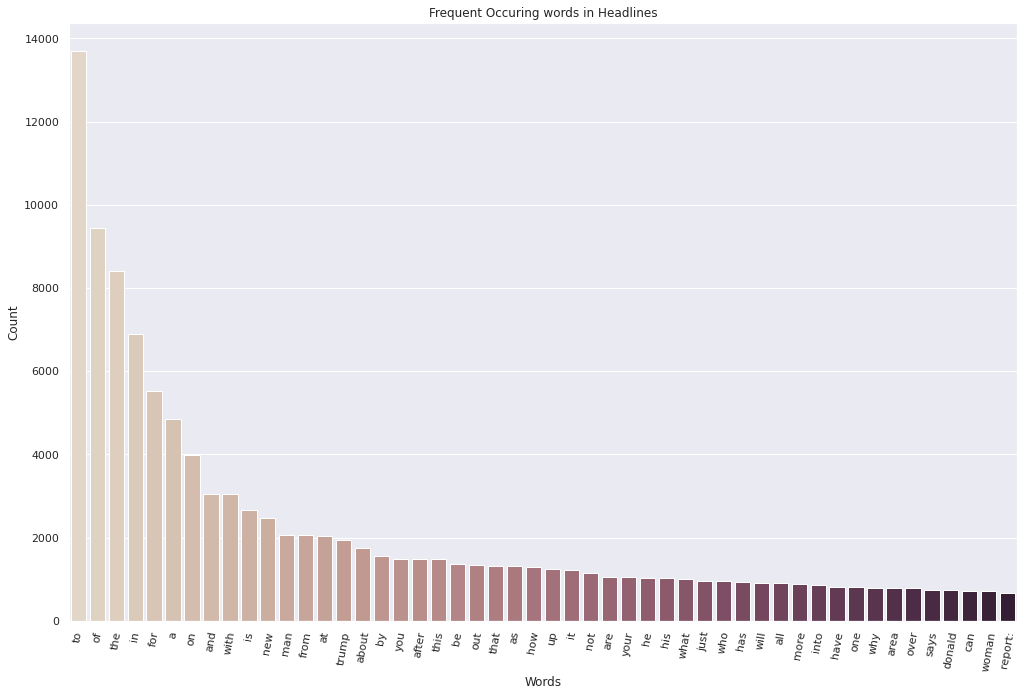

In [49]:
sar_tokens = train_data[train_data['is_sarcastic'] == 1]['headline'].apply(lambda x: nltk.word_tokenize(x))  #don't like it because of "'s'" and so on
nonsar_tokens = train_data[train_data['is_sarcastic'] == 0]['headline'].apply(lambda x: nltk.word_tokenize(x))
all_words = train_data['headline'].str.split(expand=True).unstack().value_counts()
all=pd.DataFrame(all_words).reset_index()

sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=all['index'][0:50], y=all[0][0:50], data=all,palette="ch:.25")
plt.xlabel('Words')  # Add an x-label to the axes.
plt.ylabel('Count')  # Add a y-label to the axes.
plt.title("Frequent Occuring words in Headlines") 
plt.xticks(rotation=80);

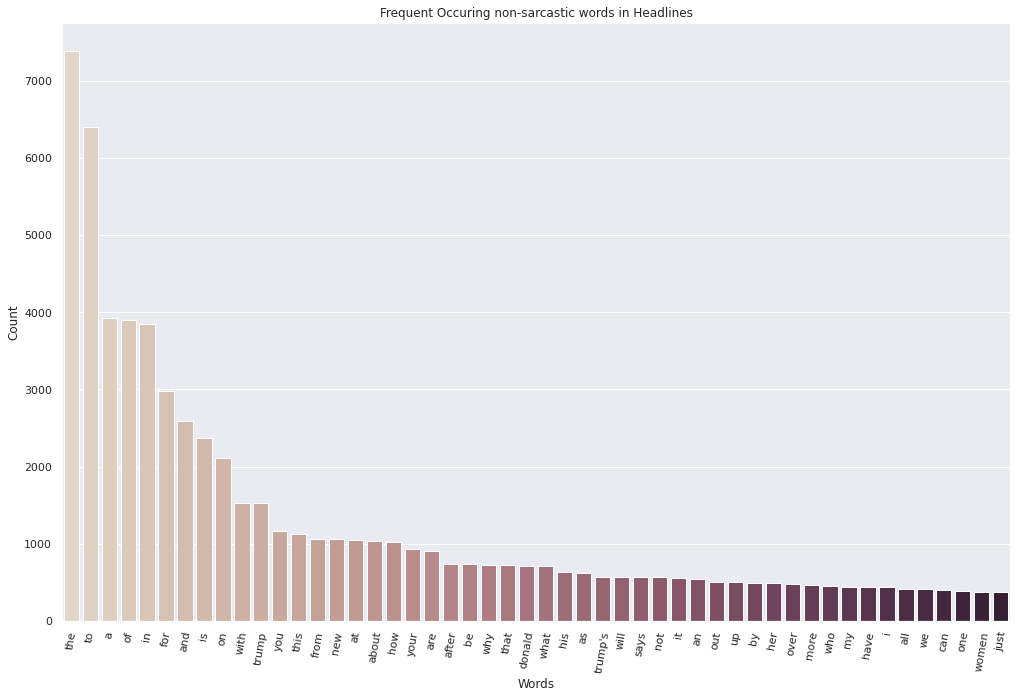

In [50]:
all_words = train_data['headline'].str.split(expand=True).unstack().value_counts()
non_sarc=pd.DataFrame(train_data[train_data['is_sarcastic']==0]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()
sarc=pd.DataFrame(train_data[train_data['is_sarcastic']==1]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()

sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=non_sarc['index'][0:50], y=non_sarc[0][0:50], data=non_sarc,palette="ch:.25")
plt.xlabel('Words')  # Add an x-label to the axes.
plt.ylabel('Count')  # Add a y-label to the axes.
plt.title("Frequent Occuring non-sarcastic words in Headlines") 
plt.xticks(rotation=80);

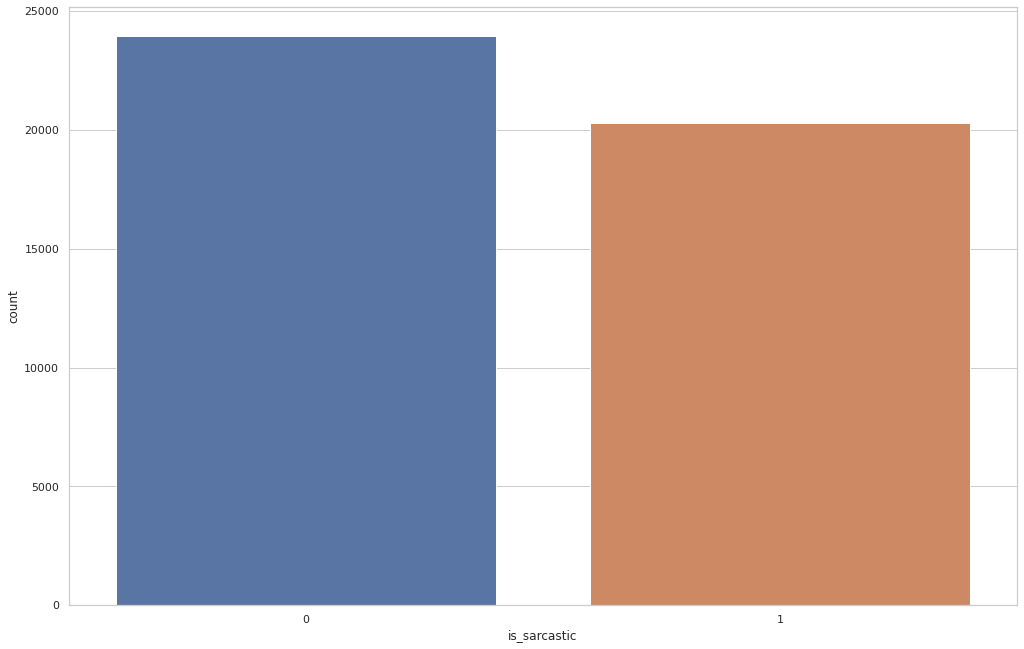

In [55]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic', data=train_data);

# Wordcloud
## Wordcloud of headline that is not sarcastic

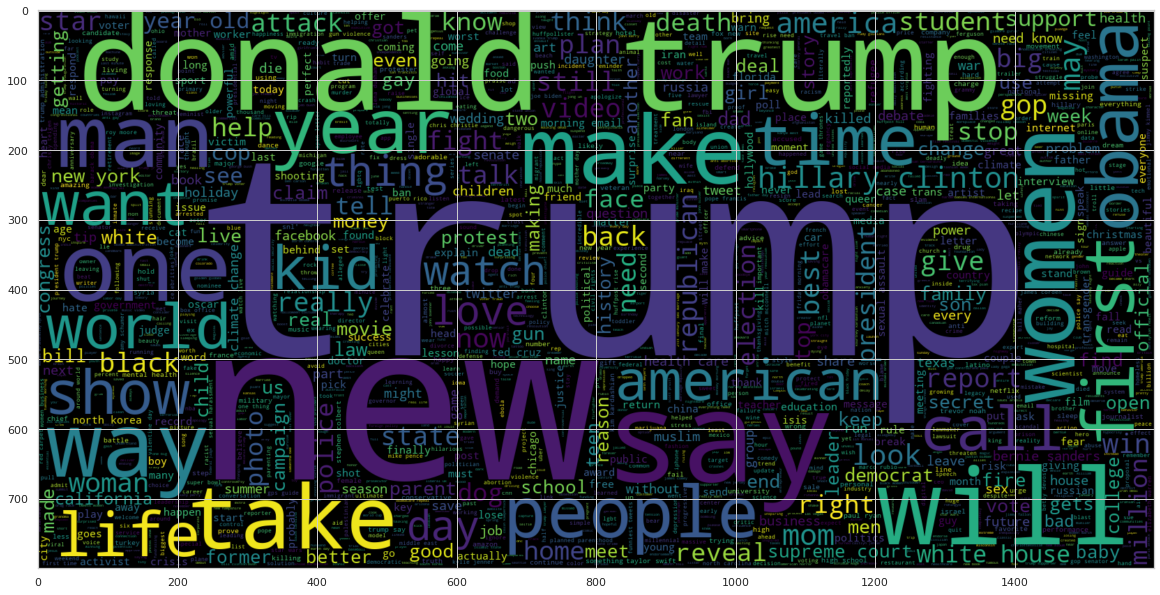

In [57]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_data[train_data.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

## Wordcloud of headline that is sarcastic

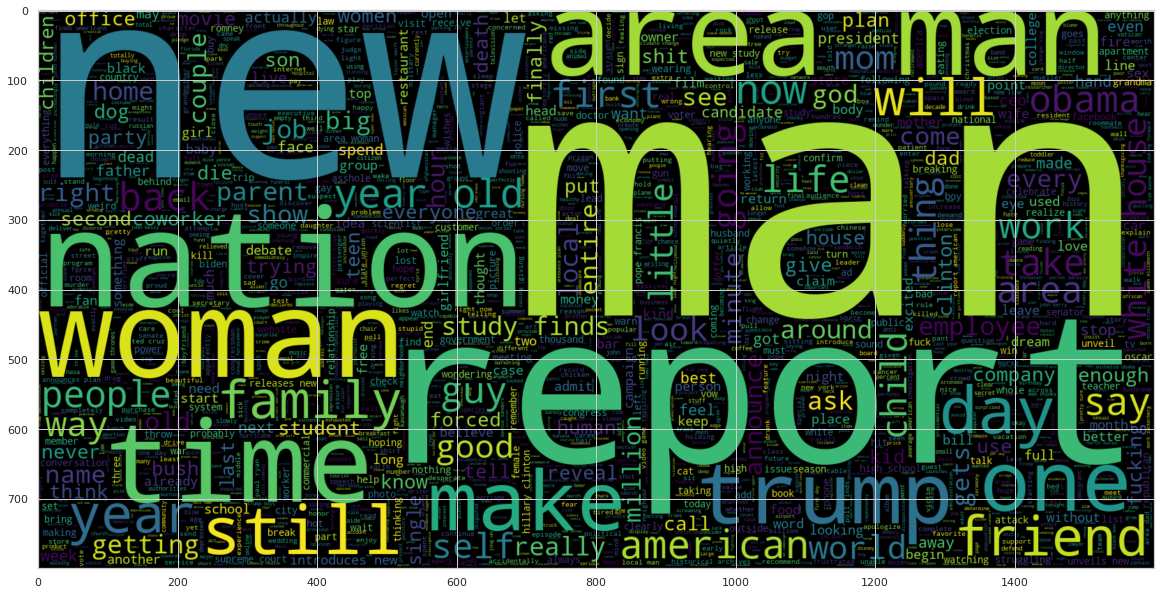

In [58]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train_data[train_data.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


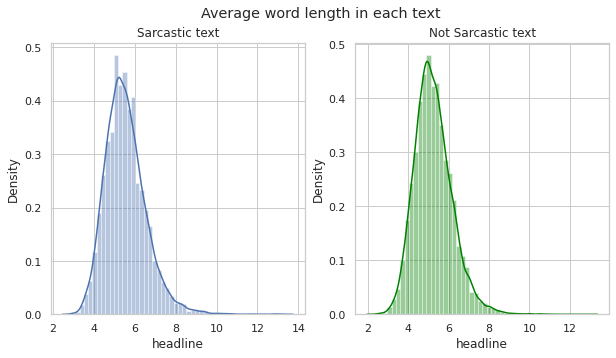

In [61]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_data[train_data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1)
ax1.set_title('Sarcastic text')
word=train_data[train_data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text');

# Data preprocessing

In [48]:
# Cleaning the text
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
corpus = []
for i in range(0, 44262):  # 44262 is the numbers of headlines in the dataset
    review = re.sub('!', ' exclamation', train_data['headline'][i]) # replace '!' with the word 'exclamation' to use it as a dimension
    review = review.replace('?', ' inquiry') # re.sub didn't work with '?'
    matches = re.findall(r'\'(.+?)\'', review) # detects quoted text from string
    if matches: # if the string contains a quotation
        review += ' quotation' # add word 'quotation' to use it as a dimension
    review = re.sub('[^a-z]', ' ', review) # removes all symbols besides lowercase letters (everything is lowercase to begin with)
    review = review.split() # split the string into a list of single words for PorterStemmer
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] # transform words to their stems and remove stopwords
    review = ' '.join(review) # join the list back to a string
    corpus.append(review) # add it to the corpus


In [8]:
# Creating the bag of words model
y = train_data.iloc[:, 1] # extracting the dependant outcomes


features_n = range(100, 3000, 100) # list of different max vectors to try
scores = []
for i in features_n:
    cv = CountVectorizer(max_features = i) # setting the max number different features
    X = cv.fit_transform(corpus).toarray() # transforming list of strings into a matrix of token counts

In [9]:
y

0        1
1        1
2        0
3        0
4        0
        ..
44257    0
44258    0
44259    0
44260    0
44261    1
Name: is_sarcastic, Length: 44262, dtype: int64

# Model building

In [11]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Naive Bayes model

In [12]:
# Fitting Naive Bayes to the Training set

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [13]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [17]:
# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

In [19]:
print("Confusion matrix : " , cm)

Confusion matrix :  [[3300 1563]
 [ 693 3297]]


In [35]:
classifier.score(X_train, y_train)

0.765850489988421

In [36]:
y_pred_nb= classifier.predict(X_test)
print('accuracy:', accuracy_score(y_test,y_pred_nb))
print('f1-score:', f1_score(y_test,y_pred_nb))

accuracy: 0.7451711284310403
f1-score: 0.7450847457627119


In [37]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      4863
           1       0.68      0.83      0.75      3990

    accuracy                           0.75      8853
   macro avg       0.75      0.75      0.75      8853
weighted avg       0.76      0.75      0.75      8853



In [38]:
acc_nb = accuracy_score(y_test,y_pred_nb)
acc_nb

0.7451711284310403

## Logistic Regression model

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
logreg.score(X_train, y_train)

0.8432037052726707

In [29]:
y_pred_logr = logreg.predict(X_test)
print('accuracy:', accuracy_score(y_test,y_pred_logr))
print('f1-score:', f1_score(y_test,y_pred_logr))

accuracy: 0.8155427538687451
f1-score: 0.7912031709500064


In [30]:
acc_logr = accuracy_score(y_test,y_pred_logr)
acc_logr

0.8155427538687451

## Random forest model

In [31]:
forest = RandomForestClassifier (criterion='gini',
                                n_estimators=12, 
                                random_state=1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=12,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [32]:
forest.score(X_train, y_train)

0.9928549238894067

In [33]:
y_pred_forest= forest.predict(X_test)
print('accuracy:', accuracy_score(y_test,y_pred_forest))
print('f1-score:', f1_score(y_test,y_pred_forest))

accuracy: 0.8890771489890432
f1-score: 0.874360286591607


In [34]:
acc_rf = accuracy_score(y_test,y_pred_forest)
acc_rf

0.8890771489890432

# Model accuracy comparison

In [40]:
models = ['LogReg', 'RandomForest', 'NaiveBayes']
col = [acc_logr, acc_rf, acc_nb]
data = {'Models':models,'Accuracy':col}
graph_df = pd.DataFrame(data)
graph_df

,Models,Accuracy
0,LogReg,0.815543
1,RandomForest,0.889077
2,NaiveBayes,0.745171


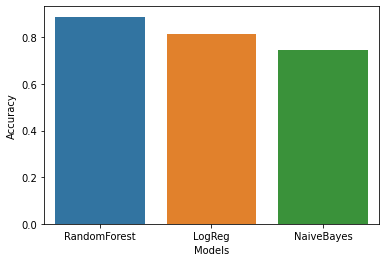

In [42]:

graph_df = graph_df.sort_values(by=['Accuracy'], axis = 0, ascending=False)

fig, ax = plt.subplots()
sns.barplot(x=graph_df['Models'], y=graph_df['Accuracy'], data=graph_df);

__We have found our best model on training data. The best model accuracy given by Random forest. We will now test new data with random forest model.__

# Prediction on new test data

In [22]:
corpus = []
for i in range(0, 11066):  # 11066 is the numbers of headlines in the dataset
    review = re.sub('!', ' exclamation', test_data['headline'][i]) # replace '!' with the word 'exclamation' to use it as a dimension
    review = review.replace('?', ' inquiry') # re.sub didn't work with '?'
    matches = re.findall(r'\'(.+?)\'', review) # detects quoted text from string
    if matches: # if the string contains a quotation
        review += ' quotation' # add word 'quotation' to use it as a dimension
    review = re.sub('[^a-z]', ' ', review) # removes all symbols besides lowercase letters (everything is lowercase to begin with)
    review = review.split() # split the string into a list of single words for PorterStemmer
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] # transform words to their stems and remove stopwords
    review = ' '.join(review) # join the list back to a string
    corpus.append(review) # add it to the corpus

In [23]:
# Creating the bag of words model
features_n = range(100, 3000, 100) # list of different max vectors to try
test_scores = []
for i in features_n:
    cv = CountVectorizer(max_features = i) # setting the max number different features
    X = cv.fit_transform(corpus).toarray() # transforming list of strings into a matrix of token counts

In [45]:
# Predicting the Test set results
predictions = forest.predict(X)
predictions

array([0, 1, 0, ..., 1, 0, 1])

In [63]:
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
prediction

# Results summary: 
We have found best accuracy results for news headline sarcastic and non sarcastic prediction by random forest model.

# Conclusion 
Last is not least. Machine learning algorithm is never ending story, it has always room to improvement by doing trial and error by using different model, hyperparameter. In this project I used simple machine learning algorithm where I get better result around 90% accuracy. I also tried other model, TF-IDF, tensorflow model, which gives me result not better than random forest, So, i decided to use random forest model for my dataset prediction. 